<a href="https://colab.research.google.com/github/hemanthsai529/load-forecasting/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


[[[1.         1.         1.         0.1301536  0.72882886]
  [1.         1.         0.9787234  0.13123147 0.72756207]
  [1.         1.         0.95744681 0.13325249 0.67214023]
  [1.         1.         0.93617021 0.13527351 0.65423106]
  [1.         1.         0.91489362 0.1379682  0.66254434]]

 [[1.         1.         0.9787234  0.13123147 0.72756207]
  [1.         1.         0.95744681 0.13325249 0.67214023]
  [1.         1.         0.93617021 0.13527351 0.65423106]
  [1.         1.         0.91489362 0.1379682  0.66254434]
  [1.         1.         0.89361702 0.14066289 0.67928173]]

 [[1.         1.         0.95744681 0.13325249 0.67214023]
  [1.         1.         0.93617021 0.13527351 0.65423106]
  [1.         1.         0.91489362 0.1379682  0.66254434]
  [1.         1.         0.89361702 0.14066289 0.67928173]
  [1.         1.         0.87234043 0.14443546 0.70233722]]]
[0.67928173 0.70233722 0.73118824]
X_train (56097, 5, 5)
y_train (56097,)
X_test (14024, 5, 5)
y_test (14024,

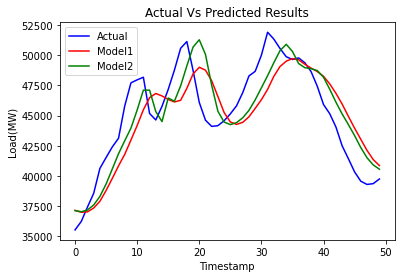

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_absolute_error

def get_data(normalized=0):
    my_data = pd.read_csv('rte-dataset.csv', header=1, error_bad_lines=False)
    df = pd.DataFrame(my_data)
    df.drop(df.columns[[0, 3, 7, 8]], axis=1, inplace=True)
#     df.drop(df.index[1000:]) 
    return df

def load_data(my_data, seq_len):
    amount_of_features = len(my_data.columns)
    data = my_data.to_numpy()
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.8 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
    print(x_train[:3])
    print(y_train[:3])
    return [x_train, y_train, x_test, y_test]


df = get_data(0)
# min_max_scaler = preprocessing.MinMaxScaler()
# nomalized = min_max_scaler.fit_transform(df.values)
values = df.values
minima = np.amin(values[:, -1])
maxima = np.amax(values[:, -1])
scaling_parameter = maxima - minima
values[:, 4] = (values[:, 4]-minima)/scaling_parameter
values[:, 0] = (values[:, 0]-np.amin(values[:, 0]))/(np.amax(values[:, 0])-np.amin(values[:, 0]))
values[:, 1] = (values[:, 1]-np.amin(values[:, 1]))/(np.amax(values[:, 1])-np.amin(values[:, 1]))
values[:, 2] = (values[:, 2]-np.amin(values[:, 2]))/(np.amax(values[:, 2])-np.amin(values[:, 2]))
values[:, 3] = (values[:, 3]-np.amin(values[:, 3]))/(np.amax(values[:, 3])-np.amin(values[:, 3]))

df = pd.DataFrame(values)
window = 5
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

def split_features(features_data_frame, seq_len):
   amount_of_features = len(features_data_frame.columns)
   data = features_data_frame.to_numpy()
   sequence_length = seq_len + 1
   result = []
   for index in range(len(data) - sequence_length):
       result.append(data[index: index + sequence_length])

   result = np.array(result)
   row = round(0.8 * result.shape[0])
   train = result[:int(row), :]
   x_train = train[:, :-1]
   y_train = train[:, -1][:, -1]
   x_test = result[int(row):, :-1]
   y_test = result[int(row):, -1][:, -1]
   x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
   x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))
   return [x_train, y_train, x_test, y_test]

# ...

window = 5
X_train, y_train, X_test, y_test = split_features(df[::-1], window)


def build_model(layers):
    model = Sequential()
    model.add(LSTM(50,input_shape=(layers[1], layers[0]),return_sequences=False))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model
model = build_model([5,window,1])
print("----------------")
print(X_train.shape)
model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.2,
    verbose=2)

# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")

def build_model2(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model
  

model2 = build_model2([5,window,1])
model2.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.2,
    verbose=2)


from matplotlib import pyplot
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


predicted1 = model.predict(X_test)
predicted2 = model2.predict(X_test)
actual = y_test



predicted1 = (predicted1*scaling_parameter)+minima
predicted2 = (predicted2*scaling_parameter)+minima
actual = (actual*scaling_parameter)+minima

mape1 = sqrt(mean_absolute_percentage_error(predicted1, actual))
mape2 = sqrt(mean_absolute_percentage_error(predicted2, actual))
print('Test MAPE1: %.3f' % mape1)
print('Test MAPE2: %.3f' % mape2)
mse1  = mean_absolute_error(actual, predicted1)
mse2  = mean_absolute_error(actual, predicted2)
print('Test MSE1: %.3f' % mse1)
print('Test MSE2: %.3f' % mse2)


pyplot.plot(actual[0:50], label='Actual', color="blue")
pyplot.plot(predicted1[0:50], label='Model1', color="red")
pyplot.plot(predicted2[0:50], label='Model2', color="green")
pyplot.xlabel("Timestamp")
pyplot.ylabel("Load(MW)")
pyplot.title("Actual Vs Predicted Results")
pyplot.legend()
pyplot.show()